In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import gpytorch
# from voltron.robinhood_utils import GetStockData
import os
# import robin_stocks.robinhood as r
import pickle5 as pickle

import sys
sys.path.append("../")
from voltron.likelihoods import VolatilityGaussianLikelihood
from voltron.kernels import BMKernel, VolatilityKernel
from voltron.models import BMGP, VoltronGP
from gpytorch.kernels import ScaleKernel, RBFKernel, MaternKernel

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
Warning no robinhood utils.


In [2]:
sns.set_style('white')
# style.use('whitegrid')
palette = ["#1b4079", "#C6DDF0", "#048A81", "#B9E28C", "#8C2155", "#AF7595", "#E6480F", "#FA9500"]
sns.set(palette = palette, font_scale=2.0, style="white", rc={"lines.linewidth": 4.0})

In [3]:
torch.random.manual_seed(400)

# Header

In [4]:
ntest = 200
ntrain = 200
tckrs = [['BAC', 'GS', 'JPM', 'MS', 'WFC'], ['COP', 'CVX', 'EOG', 'SLB', 'XOM']]
indexes = ["XLF", "XLE"]
span = "5year"
interval = 'day'
T = 5.

In [5]:
!ls ../../spdr-data/

XLE.pkl           XLK.pkl           XLY.pkl
XLF.pkl           XLRE.pkl          data_getter.ipynb


## Data Setup

['AIG' 'AON' 'AXP' 'BAC' 'BK' 'BLK' 'BRK.B' 'C' 'CB' 'CME' 'COF' 'GS'
 'ICE' 'JPM' 'MCO' 'MET' 'MMC' 'MS' 'MSCI' 'PGR' 'PNC' 'PRU' 'SCHW' 'SIVB'
 'SPGI' 'TFC' 'TROW' 'TRV' 'USB' 'WFC']


<Figure size 720x360 with 0 Axes>

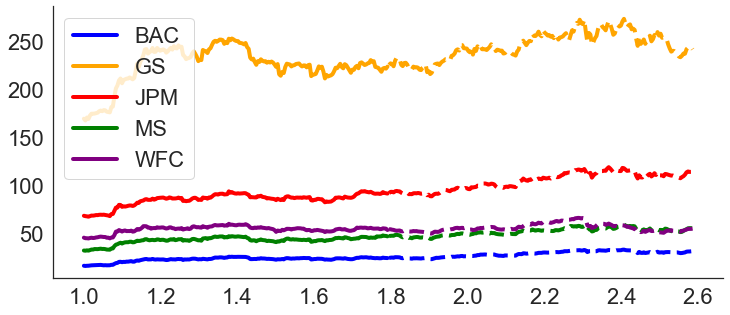

['COP' 'CVX' 'EOG' 'SLB' 'XOM']


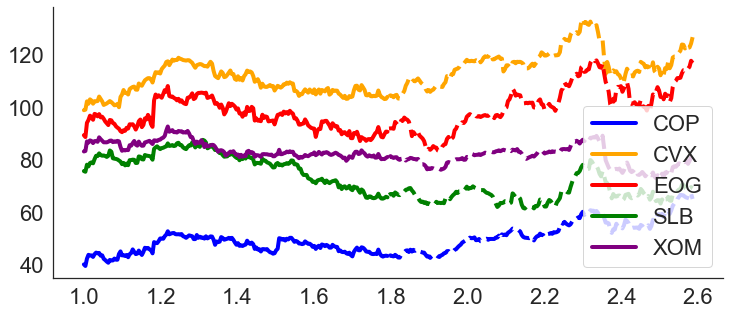

In [6]:
plt.figure(figsize = (10, 5))
idx = -2


colors = ["blue", "orange", "red", "green", "purple", "maroon"]

train_y_list = []
test_y_list = []
for j, (tckr1, loc) in enumerate(zip(tckrs, indexes)):
    with open("../../spdr-data/"+loc+".pkl", "rb") as handle:
        raw_data = pickle.load(handle)
    print(np.unique(raw_data["symbol"]))
    plt.figure(figsize = (12, 5))
    for i, tckr in enumerate(tckr1):
        data = raw_data[raw_data["symbol"] == tckr]
        ts = torch.linspace(0, T, data.shape[0]) + 1
        train_x = ts[:ntrain]
        test_x = ts[ntrain:(ntrain+ntest)]

        y = torch.FloatTensor(data['close_price'].to_numpy())
        train_y = y[:ntrain]
        test_y = y[ntrain:(ntrain+ntest)]

        dt = ts[1] - ts[0]
        train_y_list.append(train_y)
        test_y_list.append(test_y)

        plt.plot(train_x, train_y, label = tckr, color = colors[i])
        plt.plot(test_x, test_y, linestyle="--", color = colors[i])

        plt.legend()
    sns.despine()
    plt.show()

    train_y = torch.stack(train_y_list)
    test_y = torch.stack(test_y_list)


In [7]:
dt * 252

tensor(1.0016)

In [8]:
train_y.shape

torch.Size([10, 200])

In [9]:
log_returns = torch.log(train_y[..., 1:]/train_y[..., :-1])

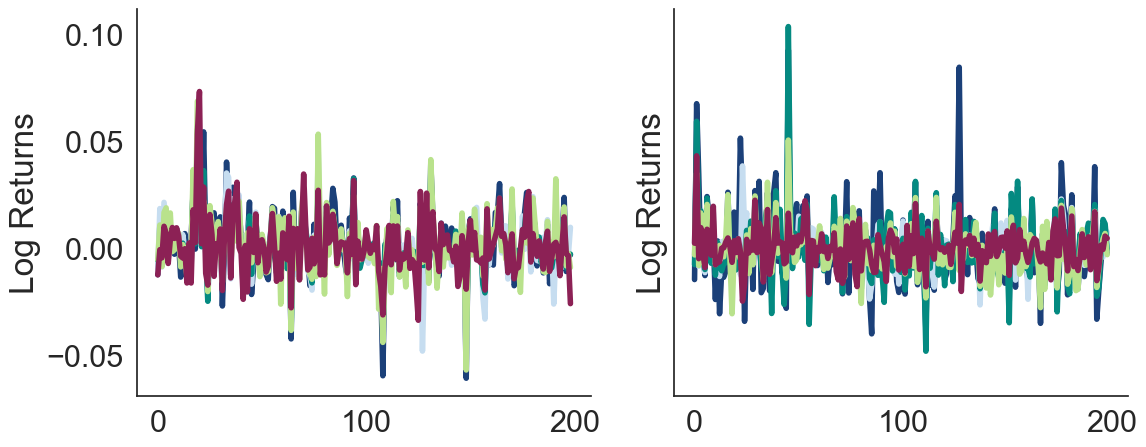

In [10]:
fig, ax = plt.subplots(1, 2, figsize = (12, 5), dpi=100, sharey=True)
ax[0].plot(log_returns[:5].t(), label='Log Returns')

ax[0].set_ylabel("Log Returns")

ax[1].plot(log_returns[5:].t(), label='Log Returns')

ax[1].set_ylabel("Log Returns")


# fig.legend()
plt.tight_layout()
sns.despine()

## Now apply GCPV

In [11]:
from voltron.models import MultitaskVariationalGP

In [12]:
train_y.shape

torch.Size([10, 200])

In [13]:
train_x[:-1].shape

torch.Size([199])

In [14]:
%pdb

Automatic pdb calling has been turned ON


In [15]:
from gpytorch.priors import LKJCovariancePrior, SmoothedBoxPrior
likelihood = VolatilityGaussianLikelihood(batch_shape=[train_y.shape[0]], param="exp")

# corresponds to ICM
covar_module = BMKernel
model = MultitaskVariationalGP(
    inducing_points=train_x[:-1], # likelihood=likelihood,
    covar_module=covar_module(), learn_inducing_locations=False,
    num_tasks = train_y.shape[0], 
    prior=LKJCovariancePrior(eta=0.5, n=train_y.shape[0], sd_prior=SmoothedBoxPrior(0.05, 1.0))
)
model.initialize_variational_parameters(likelihood=likelihood, x=train_x[:-1], y=log_returns.t())

Using gp-exp parameterization.


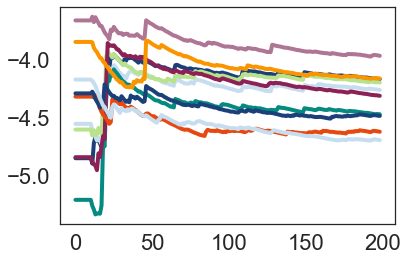

In [16]:
plt.plot(model.variational_mean.detach())

In [17]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 200


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {"params": model.parameters()}, 
], lr=0.01)

# "Loss" for GPs - the marginal log likelihood
# num_data refers to the number of training datapoints
mll = gpytorch.mlls.VariationalELBO(likelihood, model, train_x.shape[0] - 1)

In [18]:
batched_train_x = train_x[:-1]

In [19]:
%pdb

Automatic pdb calling has been turned OFF


In [20]:
print_every = 50
for i in range(training_iterations):
    # Zero backpropped gradients from previous iteration
    optimizer.zero_grad()
    # Get predictive output
    # with gpytorch.settings.num_gauss_hermite_locs(75), gpytorch.settings.max_cholesky_size(3000):
    output = model(batched_train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, log_returns.t())
    loss.backward()
    if i % print_every == 0:
        print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

Iter 1/200 - Loss: 22.503


/Users/wesleymaddox/Documents/GitHub/wjm_gpytorch/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Iter 51/200 - Loss: -24.860
Iter 101/200 - Loss: -26.641
Iter 151/200 - Loss: -26.930


In [21]:
model.eval();
likelihood.eval();
predictive = model(train_x)
pred_scale = likelihood(predictive).scale.mean(0).detach()
samples = likelihood(predictive).scale.detach()

/Users/wesleymaddox/Documents/GitHub/wjm_gpytorch/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


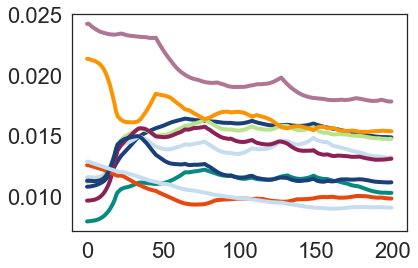

In [22]:
plt.plot(predictive.mean.detach().exp())

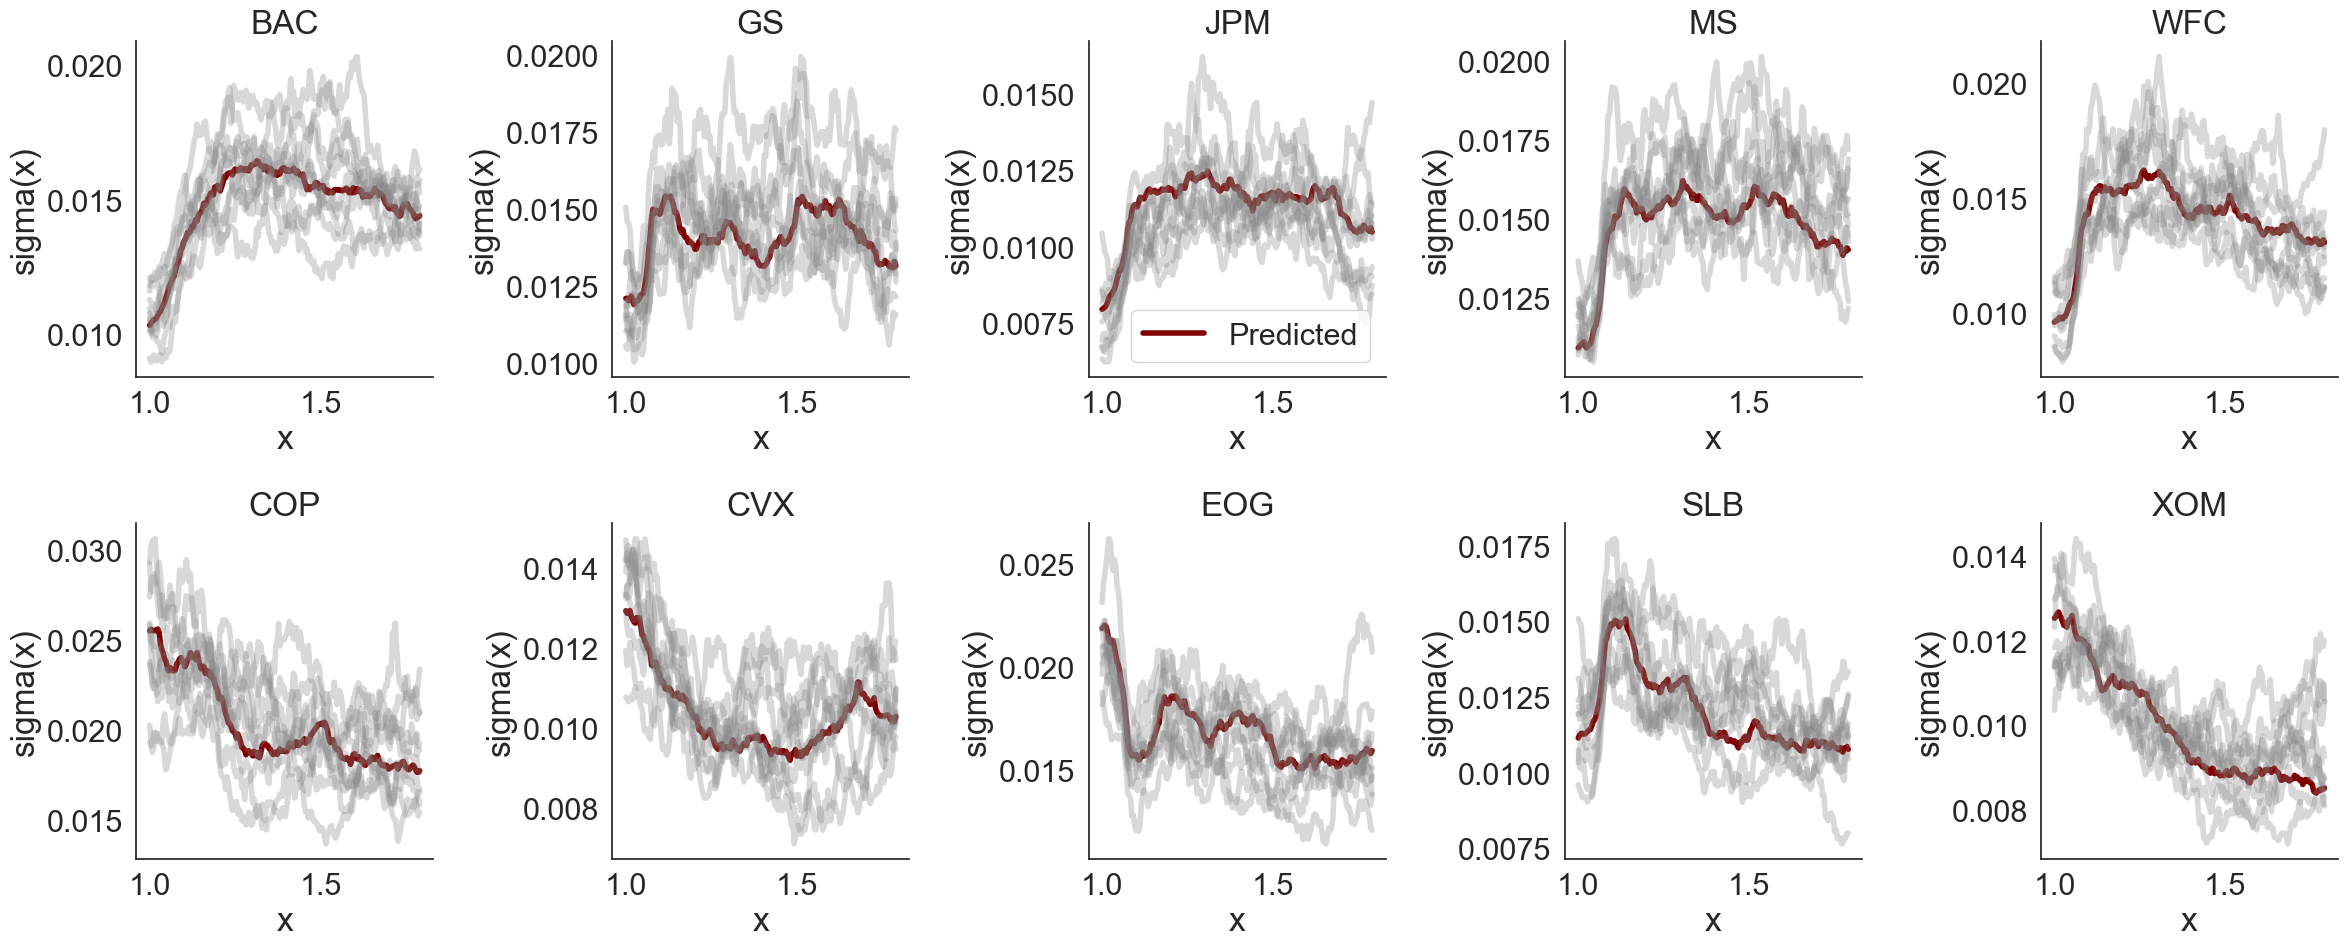

In [23]:
fig, ax = plt.subplots(2, 5, figsize = (24, 10), dpi=100)

tckrs = np.array(tckrs).reshape(-1)
ax = ax.reshape(-1)
for i in range(10):
    ax[i].plot(train_x, pred_scale[:,i], label = "Predicted", color = "maroon", linewidth=4)
    ax[i].plot(train_x, samples[..., i].t(), c='gray', alpha=0.3)
    # plt.plot(ts, V[1:], label = "Actual", color = "orangered")
    ax[i].set_xlabel("x")
    ax[i].set_ylabel("sigma(x)")
    ax[i].set_title(tckrs[i])
ax[2].legend()

# fig, ax = plt.subplots(dpi=100)
# ax.plot(train_x, pred_scale, label = "Predicted")
# ax2 = ax.twinx()
# ax2.plot(train_x, V[1:], label = "Actual", color='orangered')

# ax.set_ylabel("Predicted Vol")
# ax2.set_ylabel("Actual Vol")


plt.tight_layout()
sns.despine()

In [24]:
log_returns.shape

torch.Size([10, 199])

In [25]:
pred_scale.shape

torch.Size([200, 10])

Text(0.5, 1.0, 'Log returns')

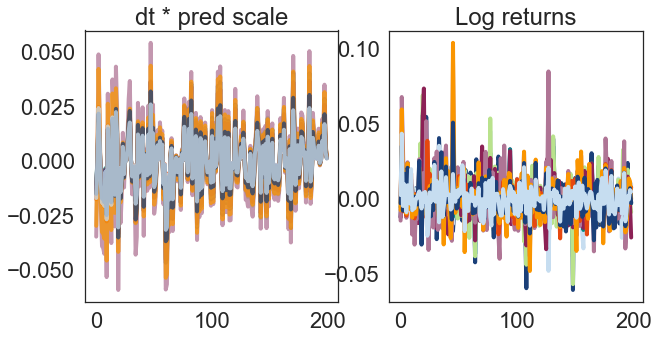

In [26]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].plot((torch.randn(pred_scale.shape[0])*pred_scale.t()).t(), alpha=0.75)
ax[1].plot(log_returns.t())

ax[0].set_title("dt * pred scale")
ax[1].set_title("Log returns")

## Now Do Forward Predictions with Voltron

In [27]:
pred_scale = pred_scale / dt**0.5

In [28]:
from voltron.models import MultitaskBMGP

In [29]:
train_x.shape

torch.Size([200])

In [30]:
pred_scale.shape

torch.Size([200, 10])

In [31]:
from gpytorch.utils.pivoted_cholesky import pivoted_cholesky

In [32]:
prior = LKJCovariancePrior(eta=0.5, n=train_y.shape[0], sd_prior=SmoothedBoxPrior(0.05, 1.0))
                         
vol_lh = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=pred_scale.shape[-1])
vol_lh.noise.data = torch.tensor([1e-6])
vol_model = MultitaskBMGP(train_x, pred_scale.log(), vol_lh, prior=prior)

optimizer = torch.optim.Adam([
    {'params': vol_model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.01)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(vol_lh, vol_model)

for i in range(500):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = vol_model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, pred_scale.log())
    loss.backward()
    if i % 50 == 0:
        print(loss.item(), vol_model.covar_module.data_covar_module.raw_vol.item())
    optimizer.step()
    
print((vol_model.covar_module.data_covar_module.raw_vol))
# print(vol_model.mean_module.constant.data.exp())

1.1445820331573486 -1.3862943649291992
0.9257243871688843 -1.0405840873718262
0.7030890583992004 -1.1147710084915161
0.4630597233772278 -1.4129424095153809
0.21245557069778442 -1.7523577213287354
-0.043949950486421585 -2.057647705078125
-0.30177825689315796 -2.3146276473999023
-0.5571383833885193 -2.536790132522583
-0.8059611320495605 -2.709737539291382
-1.0465197563171387 -2.8370165824890137
Parameter containing:
tensor([-2.9244], requires_grad=True)


In [33]:
print(train_x.shape, train_y.shape, pred_scale.shape)

torch.Size([200]) torch.Size([10, 200]) torch.Size([200, 10])


In [34]:
from voltron.means import LogLinearMean

In [35]:
voltron_lh = gpytorch.likelihoods.GaussianLikelihood()
voltron = VoltronGP(train_x, train_y.log(), voltron_lh, pred_scale.t())
# voltron.mean_module = gpytorch.means.LinearMean(1, batch_shape=torch.Size((6,)))
voltron.mean_module = LogLinearMean(input_size=1, batch_shape=torch.Size((pred_scale.shape[1],)))
voltron.mean_module.initialize_from_data(train_x, train_y.log())
voltron.likelihood.raw_noise.data = torch.tensor([1e-6])
voltron.vol_lh = vol_lh
voltron.vol_model = vol_model

grad_flags = [False, True, True, True, *[False] * len(list(vol_model.named_parameters()))]

for idx, (n, p) in enumerate(voltron.named_parameters()):
    # print(n)
    p.requires_grad = grad_flags[idx]
    
voltron.train();
voltron_lh.train();
voltron.vol_lh.train();
voltron.vol_model.train();

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': voltron.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)



In [36]:
train_y.shape

torch.Size([10, 200])

In [37]:
# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(voltron_lh, voltron)

for i in range(500):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = voltron(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y.log()).sum()
    loss.backward()
    if i % 50 == 0:
        print(loss.item())
    optimizer.step()

7.4627790451049805
7.455449104309082
7.4531755447387695
7.451430320739746
7.450198173522949
7.449359893798828
7.448797225952148
7.448419570922852
7.4481611251831055
7.4479780197143555


## Predict

In [38]:
%pdb

Automatic pdb calling has been turned ON


In [39]:
nvol = 10
npx = 10
num_tasks = pred_scale.shape[1]
vol_paths = torch.zeros(num_tasks, nvol, ntest)
px_paths = torch.zeros(num_tasks,  npx*nvol, ntest)

voltron.vol_model.eval();
voltron.eval();

for vidx in range(nvol):
    print(vidx)
    vol_pred = voltron.vol_model(test_x).sample().exp()
    vol_paths[:, vidx, :] = vol_pred.detach().t()
    
    px_pred = voltron.GeneratePrediction(test_x, vol_pred.t(), npx)
    px_pred = px_pred.exp()
    px_paths[:, vidx*npx:(vidx*npx+npx), :] = px_pred.detach().transpose(-1, -2)

0
1
2
3
4
5
6
7
8
9


In [40]:
pred_scale.shape

torch.Size([200, 10])

In [41]:
# pred_mean = voltron.mean_module(test_x).detach().exp()

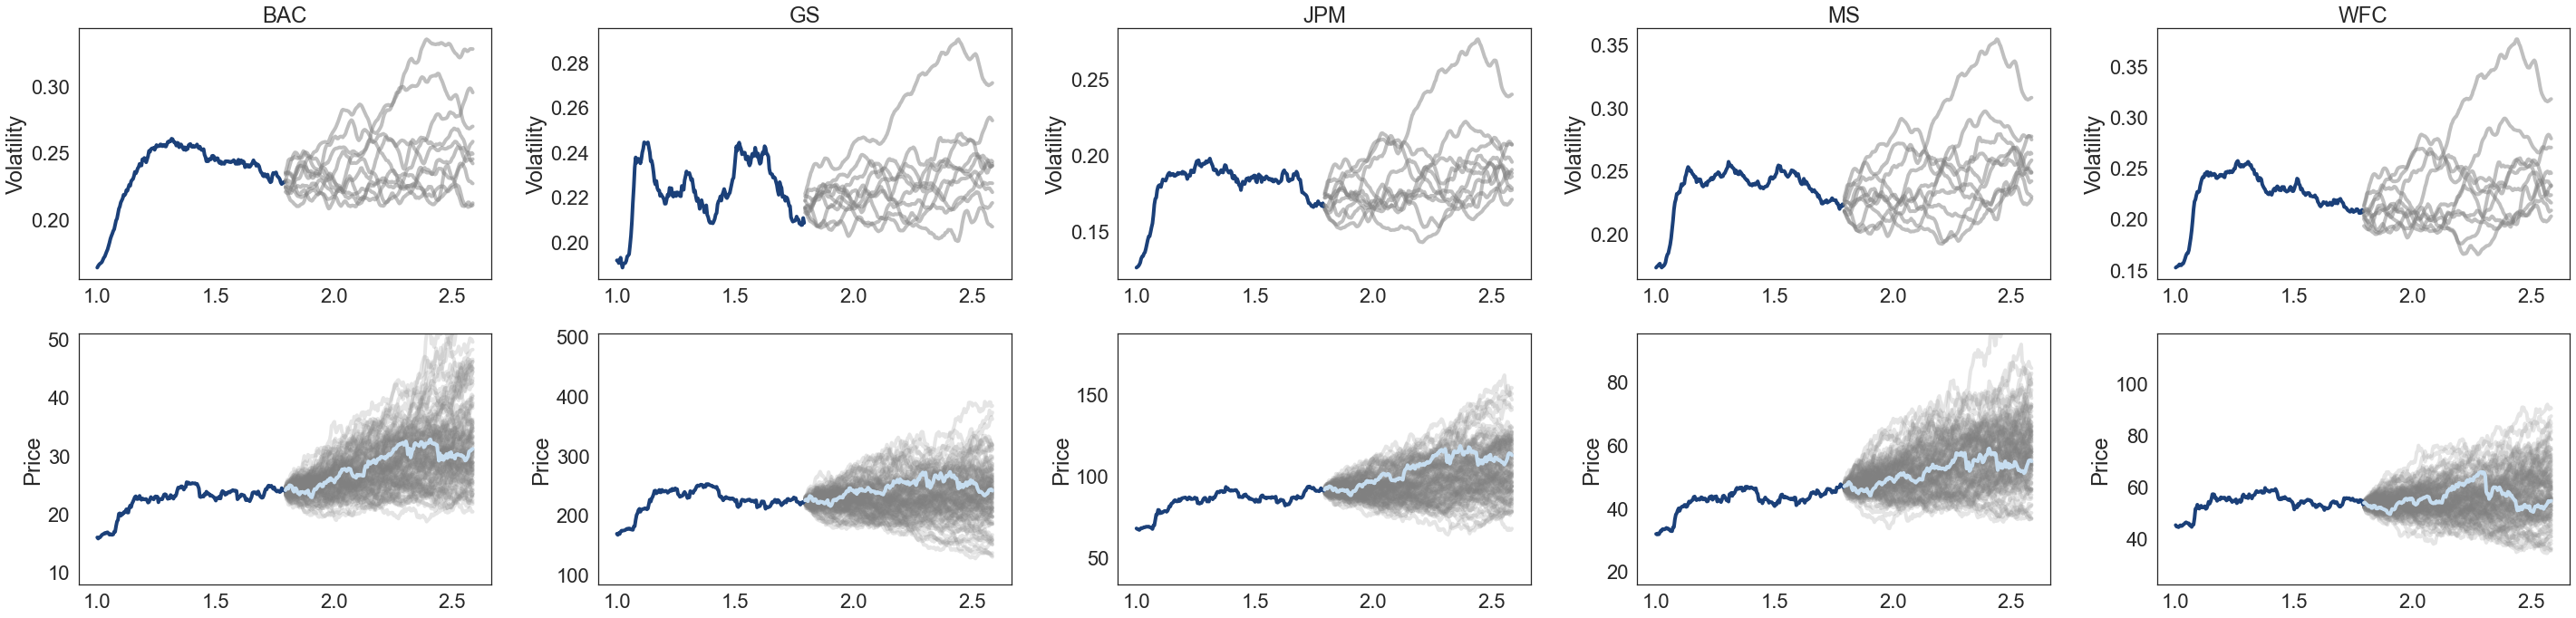

In [42]:
fig, ax = plt.subplots(2, 5, figsize = (40, 10))

for i in range(5):
    
    ax[0, i].plot(train_x, pred_scale[..., i])
    ax[0, i].plot(test_x, vol_paths[i].t(), color = "gray", alpha = 0.5)

    ax[1, i].plot(test_x, px_paths[i].t(), color = "gray", alpha = 0.2)
    # ax[1, i].plot(test_x, pred_mean.exp()[i,:,0].t(), color = "black")
    ax[1, i].plot(train_x, train_y[i])
    ax[1, i].plot(test_x, test_y[i])
    # ax[1, i].plot(test_x, pred_mean[i], lw=3.)

    # ax[0,i].set_title("Volatility")
    # ax[1,i].set_title("Price")
    ax[0, i].set_ylabel("Volatility")
    ax[1, i].set_ylabel("Price")
    ax[0, i].set_title(tckrs[i])
    # ax[0, i].set_ylim((0, 0.5))
    ax[1, i].set_ylim((0.5 * train_y[i].min(), 2.0 * train_y[i].max()))

# [ax[0, i].set_ylim((0, 0.2)) for i in range(6)]
# [ax[1, i].set_ylim((0, 150)) for i in range(6)]
plt.tight_layout()
plt.show();

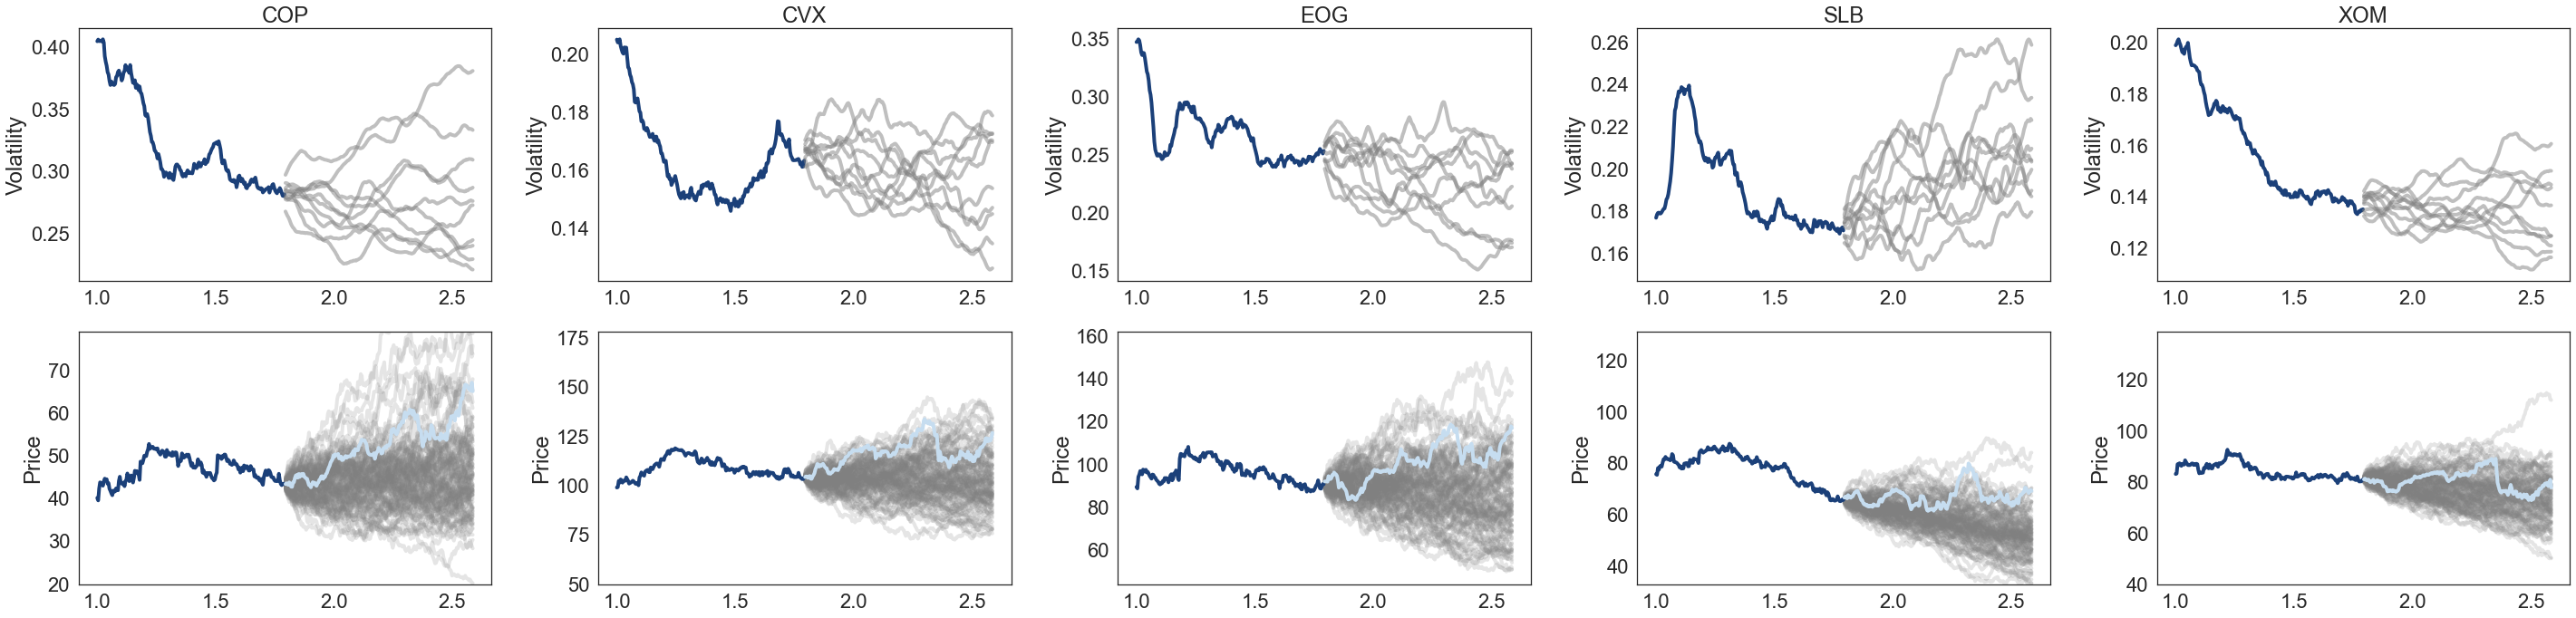

In [43]:
fig, ax = plt.subplots(2, 5, figsize = (40, 10))

for i in range(5, 10):
    j = i-5
    ax[0, j].plot(train_x, pred_scale[..., i])
    ax[0, j].plot(test_x, vol_paths[i].t(), color = "gray", alpha = 0.5)

    ax[1, j].plot(test_x, px_paths[i].t(), color = "gray", alpha = 0.2)
    # ax[1, i].plot(test_x, pred_mean.exp()[i,:,0].t(), color = "black")
    ax[1, j].plot(train_x, train_y[i])
    ax[1, j].plot(test_x, test_y[i])
    # ax[1, i].plot(test_x, pred_mean[i], lw=3.)

    # ax[0,i].set_title("Volatility")
    # ax[1,i].set_title("Price")
    ax[0, j].set_ylabel("Volatility")
    ax[1, j].set_ylabel("Price")
    ax[0, j].set_title(tckrs[i])
    # ax[0, i].set_ylim((0, 0.5))
    ax[1, j].set_ylim((0.5 * train_y[i].min(), 1.5 * train_y[i].max()))

# [ax[0, i].set_ylim((0, 0.2)) for i in range(6)]
# [ax[1, i].set_ylim((0, 150)) for i in range(6)]
plt.tight_layout()
plt.show();

In [44]:
est_inter_task_covar = voltron.vol_model.covar_module.task_covar_module.covar_matrix.evaluate()

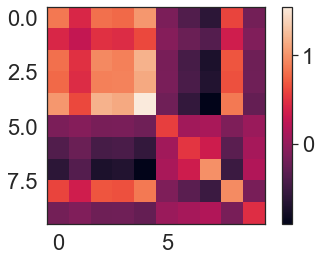

In [45]:
f = plt.imshow(est_inter_task_covar.detach())
plt.colorbar(f)

In [46]:
sqrt_inv_diag = torch.diag(est_inter_task_covar.diag().sqrt().reciprocal())
est_corr = sqrt_inv_diag.matmul(est_inter_task_covar).matmul(sqrt_inv_diag).detach()

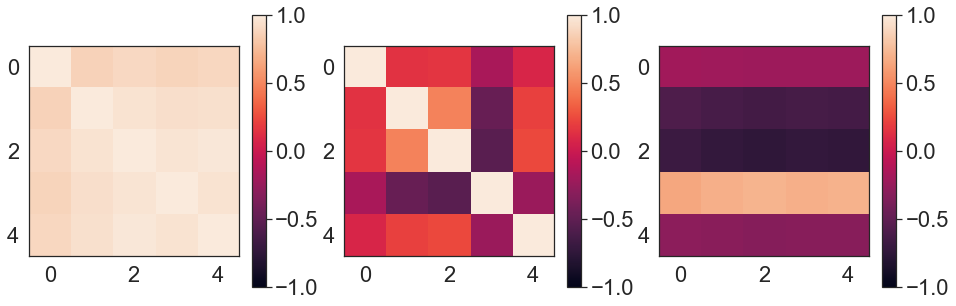

In [47]:
fig, ax = plt.subplots(1, 3, figsize = (16, 5))
f = ax[0].imshow(est_corr[:5, :5], vmin=-1., vmax=1.0)
fig.colorbar(f, ax=ax[0])

f = ax[1].imshow(est_corr[5:, 5:], vmin=-1., vmax=1.0)
fig.colorbar(f, ax=ax[1])

f = ax[2].imshow(est_corr[5:, :5], vmin=-1., vmax=1.0)
fig.colorbar(f, ax=ax[2])

Text(0.5, 1.0, 'Correlation between Stocks')

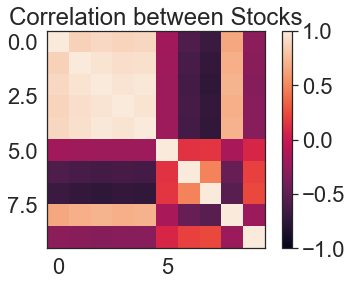

In [48]:
f = plt.imshow(est_corr.detach(), vmin=-1.0, vmax=1.0)
plt.colorbar(f)
plt.title("Correlation between Stocks")

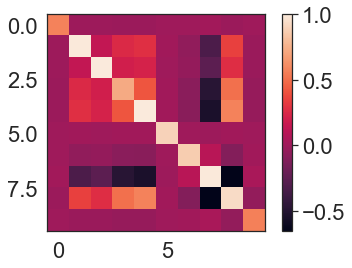

In [49]:
gpcv_covar = model.index_kernel.covar_matrix.evaluate().detach()
f = plt.imshow(gpcv_covar)
plt.colorbar(f)

In [50]:
sqrt_inv_diag = torch.diag(gpcv_covar.diag().sqrt().reciprocal())
gpcv_est_corr = sqrt_inv_diag.matmul(gpcv_covar).matmul(sqrt_inv_diag)

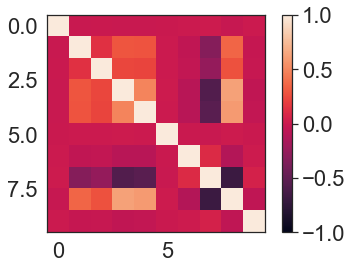

In [51]:
f = plt.imshow(gpcv_est_corr.detach(), vmin=-1.0, vmax=1.0)
plt.colorbar(f)

In [55]:
mean_paths = px_paths.mean(1)#.clamp(min=0., max=200.)
std_paths = px_paths.std(1)#.clamp(min=0., max=20.)
lower_paths = mean_paths - 2 * std_paths
upper_paths = mean_paths + 2 * std_paths

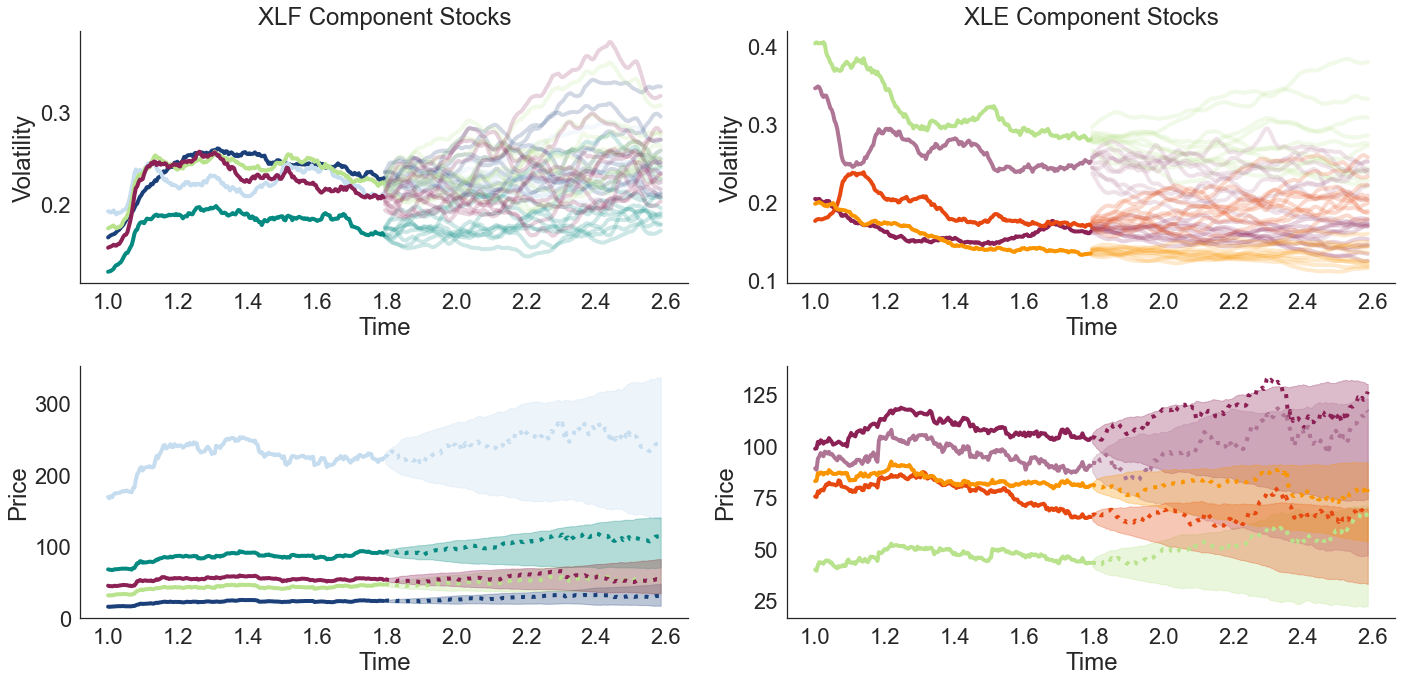

In [59]:
fig, ax = plt.subplots(2, 2, figsize = (20, 10))

[ax[0,0].plot(test_x, vol_paths[i].t(), color = palette[i], alpha = 0.2) for i in range(5)]
[ax[0,0].plot(train_x, pred_scale[..., i], color = palette[i]) for i in range(5)]
#ax[0,0].set_ylim((0, 0.6))

[ax[0,1].plot(test_x, vol_paths[i+5].t(), color = palette[i+3], alpha = 0.2) for i in range(5)]
[ax[0,1].plot(train_x, pred_scale[..., i+5], color = palette[i+3]) for i in range(5)]
# ax[0,1].set_ylim((0, 0.75))

[ax[1,0].plot(train_x, train_y[i], color = palette[i], label = tckrs[i]) for i in range(5)]
[ax[1,0].plot(test_x, test_y[i], color = palette[i], linestyle=":") for i in range(5)]

[ax[1,1].plot(train_x, train_y[i+5], color = palette[i+3]) for i in range(5)]
[ax[1,1].plot(test_x, test_y[i+5], color = palette[i+3], linestyle=":") for i in range(5)]

[ax[1,0].fill_between(test_x, lower_paths[i].t(), upper_paths[i].t(), 
                      color = palette[i], alpha = 0.3) for i in range(5)]
[ax[1,1].fill_between(test_x, lower_paths[i+5].t(), upper_paths[i+5].t(), 
                      color = palette[i+3], alpha = 0.3) for i in range(5)]

# ax[0,1].set_ylim((0, 0.4))
ax[0,0].set_title("XLF Component Stocks")
ax[0,1].set_title("XLE Component Stocks")

ax[0,0].set_xlabel("Time")
ax[0,1].set_xlabel("Time")
ax[1,0].set_xlabel("Time")
ax[1,1].set_xlabel("Time")

ax[0,0].set_ylabel("Volatility")
ax[0,1].set_ylabel("Volatility")
ax[1,0].set_ylabel("Price")
ax[1,1].set_ylabel("Price")
# ax[1,0].set_ylim((0, 150))
# ax[1,1].set_ylim((0, 150))

# ax[1,0].legend(ncol = 5, bbox_to_anchor)
plt.tight_layout()
sns.despine()
plt.savefig("mt_modelling.pdf", bbox_inches = "tight")

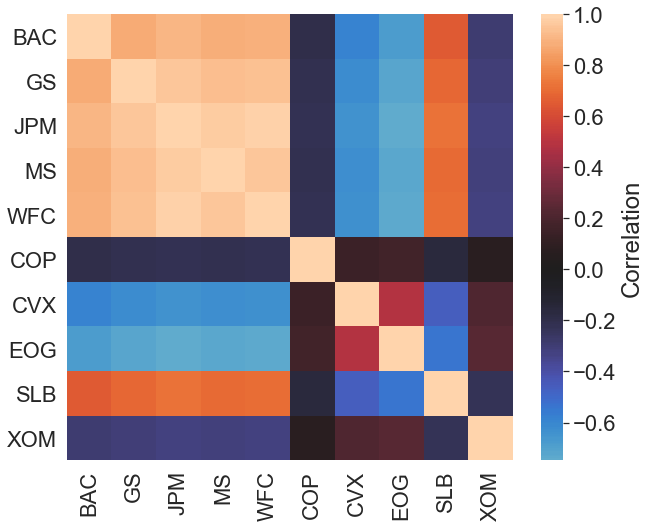

In [60]:
fig, ax = plt.subplots(figsize = (10, 10))
mask = torch.ones(10, 10).triu() - torch.eye(10)
sns.heatmap(
    est_corr.detach(), 
    # cmap="viridis", 
    center=0,
#     vmin=-1.0, 
#     vmax=1.0, 
#    mask = mask.numpy(), 
    square=True,
    cbar_kws={"label": "Correlation", "shrink": 0.82},
    # cbar_kws={"shrink": .82},
    yticklabels=tckrs,
    xticklabels=tckrs,
)
plt.savefig("mt_correlations.pdf", bbox_inches = "tight")

In [55]:
px_paths.shape

torch.Size([10, 100, 200])

In [56]:
sorted_px = px_paths.sort(1)[0]

In [57]:
emp_percentile = (px_paths > test_y.unsqueeze(-2)).sum(1) / 100

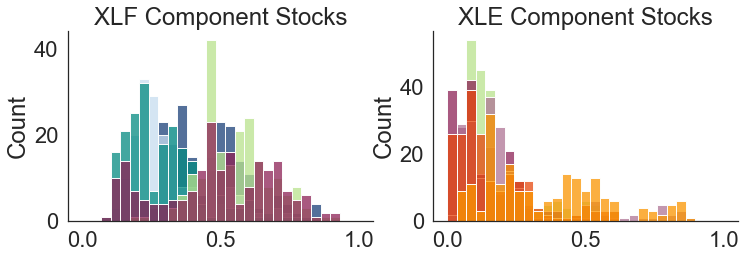

In [58]:
fig, ax = plt.subplots(1, 2, figsize = (12, 3.5))

[sns.histplot(emp_percentile.numpy()[i], ax=ax[0], color = palette[i], 
              bins=torch.linspace(0, 1, 30).numpy()) for i in range(5)]
[sns.histplot(emp_percentile.numpy()[i+5], ax=ax[1], color = palette[i+3],
             bins=torch.linspace(0, 1, 30).numpy()) for i in range(5)]

ax[0].set_title("XLF Component Stocks")
ax[1].set_title("XLE Component Stocks")
sns.despine()
# plt.savefig("mt_empirical_cdfs.pdf", bbox_inches = "tight")

In [61]:
torch.save(f="multitask_predictions.pt", obj={"paths": px_paths, "vol_paths": vol_paths, "test_y": test_y})